In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
!pip install emoji
import emoji
import re
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import copy
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from torch import nn
from torch.optim import Adam
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW
from transformers import DebertaV2Tokenizer
from collections import Counter


from google.colab import drive
drive.mount('/content/drive')

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.5 MB/s eta 0:00:00
Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#Creazione dataset, la prima colonna è il testo intero del tweet

datas = "/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_text.txt"
with open(datas, 'r', encoding='utf-8') as f:
    tweets = f.readlines()

# Rimuovi eventuali spazi vuoti o newline
tweets = [tweet.strip() for tweet in tweets]

# Crea un DataFrame
data = pd.DataFrame(tweets, columns=['text'])

labels ="/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_labels.txt"
with open(labels, 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]

data.insert(1, "label", labels2)
texts = pd.DataFrame(data, columns=["text"])
data.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


samples -> 3257
categories -> {0, 1, 2, 3}[4]
label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64


<Axes: xlabel='label'>

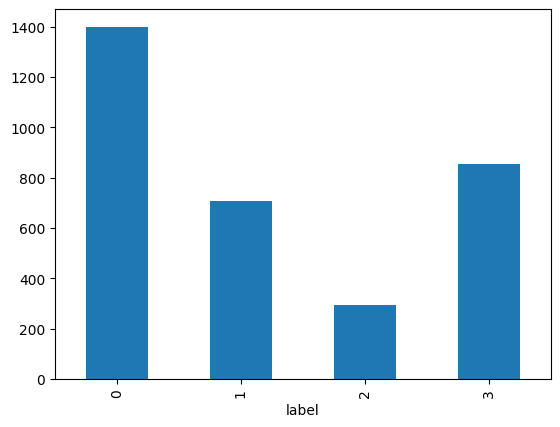

In [4]:
#Utilizzo il bert-model-cased per il task di classificazione
#0 = Rabbia
#1 = Gioia
#2 = Ottimismo
#3 = Tristezza
print('samples -> '+str(len(data)))
labels = set(data['label'])
numLabels = len(labels)
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(data['label'].value_counts())
data.groupby(['label']).size().plot.bar()

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

tokenizer = AutoTokenizer.from_pretrained(lm_model_base, token=hf_auth)
model = AutoModelForCausalLM.from_pretrained(lm_model_base, token=hf_auth)
device = 'cuda'
model.to(device)



def paraphrase_text(text, max_length=100):
    """Genera una parafrasi usando LLaMA 2"""
    if not isinstance(text, str) or text.strip() == "":
        return text  # Evita errori con valori mancanti

    prompt = f"Parafrasa la seguente frase mantenendo il significato: '{text}'"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")  # Usa GPU se disponibile

    outputs = model.generate(**inputs, max_length=max_length, temperature=0.7, top_k=50, top_p=0.95)
    paraphrased_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return paraphrased_text.replace(prompt, "").strip()  # Rimuove il prompt dal risultato

# Carichiamo il dataset
file_path = "tweets.csv"
data = pd.read_csv(file_path)

# Applichiamo la parafrasi ai tweet
data['paraphrased_text'] = data['text'].apply(paraphrase_text)

NameError: name 'lm_model_base' is not defined

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# Mappa delle etichette
label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}


emoji_freq = {emotion: Counter() for emotion in label_map.values()}
total_emoji_count = Counter()

# De-emojizzazione del testo
data['text'] = data['text'].apply(lambda text: emoji.demojize(text, delimiters=(" :", ": ")))

for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]

    emojis = [word for word in text.split() if word.startswith(":") and word.endswith(":")]

    for emj in emojis:
        emoji_freq[label][emj] += 1
        total_emoji_count[emj] += 1

normalized_emoji_freq = {emotion: Counter() for emotion in emoji_freq.keys()}

# Calcolo dello score logaritmico
for emotion, counter in emoji_freq.items():
    for emj, count in counter.items():
        term_freq = count / total_emoji_count[emj]
        log_weighted_freq = term_freq * np.log(total_emoji_count[emj] + 1)
        normalized_emoji_freq[emotion][emj] = log_weighted_freq

# Funzione per ottenere il vettore di punteggi per ogni tweet
def get_tweet_emoji_vector(text):
    emojis = [word for word in text.split() if word.startswith(":") and word.endswith(":")]

    emotion_scores = {emotion: 0 for emotion in label_map.values()}

    for emj in emojis:
        for emotion in normalized_emoji_freq:
            emotion_scores[emotion] += normalized_emoji_freq[emotion].get(emj, 0)

    num_emojis = len(emojis)
    if num_emojis > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_emojis

    return list(emotion_scores.values())

# Aggiungzione feature al dataset
data['emoji_emotion_scores'] = data['text'].apply(get_tweet_emoji_vector)

# Visualizzazione dei risultati
for emotion, counter in normalized_emoji_freq.items():
    top_emojis = counter.most_common(10)
    emojis, freqs = zip(*top_emojis) if top_emojis else ([], [])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emojis), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 emoji (logaritmo pesato) per {emotion}")
    plt.xlabel("Emoji")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
data

In [ ]:
pos_freq = {emotion: Counter() for emotion in label_map.values()}
total_pos_count = Counter()

for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    for _, tag in tagged:
        pos_freq[label][tag] += 1
        total_pos_count[tag] += 1

# Normalizzazione PoS
normalized_pos_freq = {emotion: Counter() for emotion in pos_freq.keys()}
for emotion, counter in pos_freq.items():
    for tag, count in counter.items():
        term_freq = count / total_pos_count[tag]
        log_weighted_freq = term_freq * np.log(total_pos_count[tag] + 1)
        normalized_pos_freq[emotion][tag] = log_weighted_freq

# Funzione per ottenere il vettore di punteggi per ogni tweet basato su PoS
def get_tweet_pos_vector(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    emotion_scores = {emotion: 0 for emotion in label_map.values()}
    for _, tag in tagged:
        for emotion in normalized_pos_freq:
            emotion_scores[emotion] += normalized_pos_freq[emotion].get(tag, 0)
    num_tags = len(tagged)
    if num_tags > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_tags
    return list(emotion_scores.values())

data['pos_emotion_scores'] = data['text'].apply(get_tweet_pos_vector)


for emotion, counter in normalized_pos_freq.items():
    top_pos = counter.most_common(10)
    pos_tags, freqs = zip(*top_pos) if top_pos else ([], [])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(pos_tags), y=list(freqs), palette="magma")
    plt.title(f"Top 10 PoS (logaritmo pesato) per {emotion}")
    plt.xlabel("Parti del discorso")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
data

In [ ]:
'''
# Funzione per contare i PoS
def extract_pos_counts(text):
    tokens = word_tokenize(text)  # Tokenizza il testo
    tagged = pos_tag(tokens)
    pos_counts = [0, 0, 0, 0]

    for _, tag in tagged:
        if tag.startswith('JJ'):    # Aggettivi
            pos_counts[0] += 1
        elif tag.startswith('VB'):  # Verbi
            pos_counts[1] += 1
        elif tag.startswith('NN'):  # Sostantivi
            pos_counts[2] += 1
        elif tag.startswith('RB'):  # Avverbi
            pos_counts[3] += 1
    return pos_counts


# Applicare la funzione e creare una lista di conteggi
data['pos_counts'] = data['text'].apply(extract_pos_counts)

df_pos = pd.DataFrame(data['pos_counts'].tolist(), columns=['JJ', 'VB', 'NN', 'RB'])
data = pd.concat([data, df_pos], axis=1)
data = data.drop(columns=['pos_counts'])

'''


In [ ]:
stop_words = set(stopwords.words('english'))
pos_map = {
    'JJ': 'Aggettivi',
    'NN': 'Sostantivi',
    'RB': 'Avverbi',
}

word_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_word_count = Counter()

label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}


for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words and not word.startswith('#')]

    tagged_words = pos_tag(tokens)

    for word, pos in tagged_words:
        if pos in pos_map:
            word_freq[label][word] += 1
            total_word_count[word] += 1

normalized_word_freq = {emotion: Counter() for emotion in word_freq.keys()}

for emotion, counter in word_freq.items():
    for word, count in counter.items():
        term_freq = count / total_word_count[word]
        log_weighted_freq = term_freq * np.log(total_word_count[word] + 1)
        normalized_word_freq[emotion][word] = log_weighted_freq

for emotion, counter in normalized_word_freq.items():
    print(f"\nTop 10 parole con logaritmo pesato per {emotion}:")
    for word, freq in counter.most_common(10):
        print(f"{word}: {freq:.4f}")

for emotion, counter in normalized_word_freq.items():
    top_words = counter.most_common(20)
    words, freqs = zip(*top_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 parole (logaritmo pesato) per {emotion}")
    plt.xlabel("Parole")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
word_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_word_count = Counter()

for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    tagged_words = pos_tag(tokens)
    for word, pos in tagged_words:
        if pos in pos_map:
            word_freq[label][word] += 1
            total_word_count[word] += 1


normalized_word_freq = {emotion: Counter() for emotion in word_freq.keys()}

for emotion, counter in word_freq.items():
    for word, count in counter.items():
        term_freq = count / total_word_count[word]
        log_weighted_freq = term_freq * np.log(total_word_count[word] + 1)
        normalized_word_freq[emotion][word] = log_weighted_freq


def get_tweet_vector(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    emotion_scores = {'Rabbia': 0, 'Gioia': 0, 'Ottimismo': 0, 'Tristezza': 0}

    for word in tokens:
        for emotion in normalized_word_freq:
            emotion_scores[emotion] += normalized_word_freq[emotion].get(word, 0)

    num_words = len(tokens)
    if num_words > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_words
    return list(emotion_scores.values())

tweet_vectors = []
for _, row in data.iterrows():
    tweet_vector = get_tweet_vector(row['text'])
    tweet_vectors.append(tweet_vector)

tweet_feature_data = pd.DataFrame(tweet_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])

data['words_emotion_scores'] = tweet_feature_data.values.tolist()
data

In [ ]:
data['word_count'] = data['text'].apply(lambda x: len(x.split())) # quantità di parole
data['text_length'] = data['text'].apply(len)                     # lunghezza del testo
data

In [ ]:
from collections import Counter

data['hashtags'] = data['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))

hashtag_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_hashtag_count = Counter()

for _, row in data.iterrows():
    hashtags = row['hashtags']
    label = label_map[row['label']]

    for hashtag in hashtags:
        hashtag_freq[label][hashtag] += 1
        total_hashtag_count[hashtag] += 1
normalized_hashtag_freq = {emotion: Counter() for emotion in hashtag_freq.keys()}

for emotion, counter in hashtag_freq.items():
    for hashtag, count in counter.items():
        term_freq = count / total_hashtag_count[hashtag]
        log_weighted_freq = term_freq * np.log(total_hashtag_count[hashtag] + 1)
        normalized_hashtag_freq[emotion][hashtag] = log_weighted_freq

for emotion, counter in normalized_hashtag_freq.items():
    print(f"\nTop 10 hashtag con logaritmo pesato per {emotion}:")
    for hashtag, freq in counter.most_common(10):
        print(f"{hashtag}: {freq:.4f}")

for emotion, counter in normalized_hashtag_freq.items():
    top_hashtags = counter.most_common(20)
    hashtags, freqs = zip(*top_hashtags)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 hashtag (logaritmo pesato) per {emotion}")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
def get_hashtag_vector(hashtags):
    emotion_scores = {'Rabbia': 0, 'Gioia': 0, 'Ottimismo': 0, 'Tristezza': 0}

    for hashtag in hashtags:
        for emotion in normalized_hashtag_freq:
            emotion_scores[emotion] += normalized_hashtag_freq[emotion].get(hashtag, 0)
    return list(emotion_scores.values())
data['hastag_emotion_scores'] = data['hashtags'].apply(get_hashtag_vector)
data = data.drop(columns=['hashtags'])



In [ ]:
data

In [ ]:
enc = OrdinalEncoder()
labels = data["label"]
data2 = data.drop("text", axis=1)

In [ ]:
#data2['JJ'] = [x[0] for x in data['pos_counts']]
#data2['VB'] = [x[1] for x in data['pos_counts']]
#data2['NN'] = [x[2] for x in data['pos_counts']]
#data2['RB'] = [x[3] for x in data['pos_counts']]
data2['emoji_rabbia_scores'] = [x[0] for x in data['emoji_emotion_scores']]
data2['emoji_gioia_scores'] = [x[1] for x in data['emoji_emotion_scores']]
data2['emoji_optym_scores'] = [x[2] for x in data['emoji_emotion_scores']]
data2['emoji_tristezza_scores'] = [x[3] for x in data['emoji_emotion_scores']]
data2['word_rabbia_scores'] = [x[0] for x in data['words_emotion_scores']]
data2['word_gioia_scores'] = [x[1] for x in data['words_emotion_scores']]
data2['word_optym_scores'] = [x[2] for x in data['words_emotion_scores']]
data2['word_tristezza_scores'] = [x[3] for x in data['words_emotion_scores']]
data2['hastag_rabbia_scores'] = [x[0] for x in data['hastag_emotion_scores']]
data2['hastag_gioia_scores'] = [x[1] for x in data['hastag_emotion_scores']]
data2['hastag_optym_scores'] = [x[2] for x in data['hastag_emotion_scores']]
data2['hastag_tristezza_scores'] = [x[3] for x in data['hastag_emotion_scores']]
data2['pos_rabbia_scores'] = [x[0] for x in data['pos_emotion_scores']]
data2['pos_gioia_scores'] = [x[1] for x in data['pos_emotion_scores']]
data2['pos_optym_scores'] = [x[2] for x in data['pos_emotion_scores']]
data2['pos_tristezza_scores'] = [x[3] for x in data['pos_emotion_scores']]

In [ ]:
data2 = data2.drop(columns=['emoji_emotion_scores','words_emotion_scores','hastag_emotion_scores', 'pos_emotion_scores'])
data2.info()

In [ ]:
data2

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data2.corr(), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Matrice di correlazione tra le feature")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators':[100, 150, 200],
    'criterion':('gini', 'entropy', 'log_loss'),
    'max_depth':[5, 10, 20, None]
}

forest = RandomForestClassifier(random_state=42)
grid = GridSearchCV(forest, parameters, scoring='accuracy') # mi serve per trovare le migliori combinazioni di iperparametri
grid.fit(data2, labels) # addestro la gridSearch

best_model = grid.best_estimator_
best_accuracy = grid.best_score_
best_params = grid.best_params_
print(f'Il miglior modello ha accuracy {best_accuracy} ed i suoi migliori parametri sono {best_params}')

In [ ]:
from sklearn.feature_selection import SelectFromModel

sf = SelectFromModel(estimator=best_model)
sf.fit_transform(data2, labels)
print(sf.get_feature_names_out())

In [ ]:
#Ricreo il dataset finale con le feature estratte + il testo completo
data3 = data2[['word_rabbia_scores','word_gioia_scores', 'word_optym_scores', 'word_tristezza_scores']]
data3.insert(0, "text", data["text"])
data3.insert(5, "label",labels)
data3

In [ ]:
x_train = data3['text']
y_train = data3['label']
word_rabbia_scores = data3['word_rabbia_scores']
word_gioia_scores = data3['word_gioia_scores']
word_optym_scores = data3['word_optym_scores']
word_tristezza_scores = data3['word_tristezza_scores']

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/val_text.txt", 'r', encoding='utf-8') as f:
    tweets = f.readlines()

# Rimuovi eventuali spazi vuoti o newline
tweets = [tweet.strip() for tweet in tweets]
val_text_df = pd.DataFrame(tweets, columns=['text'])

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/val_labels.txt", 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]

val_data = pd.DataFrame(tweets, columns=['text'])
val_data['label'] = labels2
val_data

In [ ]:
# Applicazione della funzione ai tweet e creazione delle feature
tweet_vectors = []
for _, row in val_data.iterrows():
    tweet_vector = get_tweet_vector(row['text'])
    tweet_vectors.append(tweet_vector)

# Convertilo in un DataFrame per visualizzare le feature
tweet_feature_data = pd.DataFrame(tweet_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])
val_data['words_emotion_scores'] = tweet_feature_data.values.tolist()

val_data['word_rabbia_scores'] = [x[0] for x in val_data['words_emotion_scores']]
val_data['word_gioia_scores'] = [x[1] for x in val_data['words_emotion_scores']]
val_data['word_optym_scores'] = [x[2] for x in val_data['words_emotion_scores']]
val_data['word_tristezza_scores'] = [x[3] for x in val_data['words_emotion_scores']]
val_data = val_data.drop(columns=['words_emotion_scores'])
val_data


In [ ]:
x_val = val_data['text']
word_rabbia_scores_val = val_data['word_rabbia_scores']
word_gioia_scores_val = val_data['word_gioia_scores']
word_optym_scores_val = val_data['word_optym_scores']
word_tristezza_scores_val = val_data['word_tristezza_scores']
label_val = val_data['label']

In [ ]:
x_train = x_train.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
x_val = x_val.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, y, stopwords):

        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]
        self.word_rabbia_scores = [torch.tensor(score) for score in word_rabbia_scores]
        self.word_gioia_scores = [torch.tensor(score) for score in word_gioia_scores]
        self.word_optym_scores = [torch.tensor(score) for score in word_optym_scores]
        self.word_tristezza_scores = [torch.tensor(score) for score in word_tristezza_scores]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])
        batch_word_rabbia_scores = np.array(self.word_rabbia_scores[idx])
        batch_word_gioia_scores = np.array(self.word_gioia_scores[idx])
        batch_word_optym_scores = np.array(self.word_optym_scores[idx])
        batch_word_tristezza_scores = np.array(self.word_tristezza_scores[idx])

        return batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batch_labels

In [ ]:
#Iperparametri della rete
#Uso il modello bertweet-base
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-5,
    "batch_size": 16,
    "dropout": 0.1,
    "stopwords": False,
    "language_model": "vinai/bertweet-base",
    "layers": 1,
    "h_dim": 768,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01,
}

In [ ]:
#!pip install emoji
#Installo la libreria emoji per trasformare le emoji di un testo in caratteri

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
word_rabbia_scores_val = val_data['word_rabbia_scores']
word_gioia_scores_val = val_data['word_gioia_scores']
word_optym_scores_val = val_data['word_optym_scores']
word_tristezza_scores_val = val_data['word_tristezza_scores']

In [ ]:
#creo i dataset
train_dataset = Dataset(x_train, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, word_rabbia_scores_val, word_gioia_scores_val, word_optym_scores_val, word_tristezza_scores_val ,label_val, hyperparameters["stopwords"])

In [ ]:
extra_features = 4

class ClassifierDeep(nn.Module):
    def __init__(self, labels, hdim, dropout, model_name):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)

        # Proiezione dell'output di BERT
        self.bert_projection = nn.Sequential(
            nn.Linear(hdim, hdim),
            nn.BatchNorm1d(hdim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Proiezione delle extra features
        self.extra_feature_projection = nn.Sequential(
            nn.Linear(extra_features, hdim // 2),
            nn.BatchNorm1d(hdim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Classificatore finale
        self.classifier = nn.Sequential(
            nn.Linear(hdim + (hdim // 2), hdim),
            nn.BatchNorm1d(hdim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim, labels)
        )

    def forward(self, input_id_text, attention_mask, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores):

        # Output da BERT
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:, 0, :]  # CLS token
        output = self.bert_projection(output)

        # Extra features (PoS, emoji scores)
        extra_features = torch.cat((word_rabbia_scores.unsqueeze(1), word_gioia_scores.unsqueeze(1),
                                    word_optym_scores.unsqueeze(1), word_tristezza_scores.unsqueeze(1)), dim=1)
        extra_features = self.extra_feature_projection(extra_features)

        # Fusione delle rappresentazioni
        combined = torch.cat((output, extra_features), dim=1)
        return self.classifier(combined)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramento della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza

In [ ]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        batch_word_rabbia_scores = batch_word_rabbia_scores.float().to(device)
        batch_word_gioia_scores = batch_word_gioia_scores.float().to(device)
        batch_word_optym_scores = batch_word_optym_scores.float().to(device)
        batch_word_tristezza_scores = batch_word_tristezza_scores.float().to(device)

        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores).squeeze(1)

        # la loss è una CrossEntropyLoss, al suo interno ha
        # la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni
        # applicando manualmente la logsoftmax
        #softmax = nn.LogSoftmax(dim=1)
        #epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()
        preds = output.argmax(dim=1)
        epoch_acc += (preds == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        batch_word_rabbia_scores = batch_word_rabbia_scores.detach().cpu()
        batch_word_gioia_scores = batch_word_gioia_scores.detach().cpu()
        batch_word_optym_scores = batch_word_optym_scores.detach().cpu()
        batch_word_tristezza_scores = batch_word_tristezza_scores.detach().cpu()

        output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, tokenizer, loss, device, scheduler):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batch_labels in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            batch_word_rabbia_scores = batch_word_rabbia_scores.float().to(device)
            batch_word_gioia_scores = batch_word_gioia_scores.float().to(device)
            batch_word_optym_scores = batch_word_optym_scores.float().to(device)
            batch_word_tristezza_scores = batch_word_tristezza_scores.float().to(device)

            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores).squeeze(1)

            # la loss è una CrossEntropyLoss, al suo interno ha
            # la logsoftmax + negative log likelihood loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni
            # applicando manualmente la logsoftmax
            #softmax = nn.LogSoftmax(dim=1)
            #preds = softmax(output).argmax(dim=1)
            #epoch_acc += (preds == batch_labels).sum().item()
            preds = output.argmax(dim=1)
            epoch_acc += (preds == batch_labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            batch_word_rabbia_scores = batch_word_rabbia_scores.detach().cpu()
            batch_word_gioia_scores = batch_word_gioia_scores.detach().cpu()
            batch_word_optym_scores = batch_word_optym_scores.detach().cpu()
            batch_word_tristezza_scores = batch_word_tristezza_scores.detach().cpu()

            output = output.detach().cpu()
    scheduler.step(epoch_loss)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss / len(dataloader), epoch_acc, f1

In [ ]:
def train_test(model, epochs, optimizer, device, train_data,
               batch_size, model_name, train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    #test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    preds = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc, f1 = test_loop(model, val_dataloader, tokenizer, test_loss_fn, device, scheduler)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        #epoch_test_loss, epoch_test_acc, f1 = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device)
        #test_loss.append(epoch_test_loss)
        #test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} 'if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nF1 score: {f1:.4f}")
        print(f"\nTrain loss: {epoch_train_loss:6.4f} ---- {val_loss_str}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} ---- {val_acc_str}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, train_acc, validation_acc, f1

In [ ]:
#GRID SEARCH PER TROVARE I PARAMETRI MIGLIORI
param_grid = {
    "epochs":[20],
    "learning_rate": [1e-3],
    "batch_size": [32],
    "dropout": [0.2],
    "weight_decay": [0.0001]
}

best_f1 = 0
best_train_loss = 0
best_val_loss = 0
best_train_acc = 0
best_val_acc = 0
best_params={}
f1_value=0

grid = ParameterGrid(param_grid)
for params in grid:
  print("----------------------------------------------------------------")
  print(params)
  # Acquisiamo il device su cui effettueremo il training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using {device} device")

  model = ClassifierDeep(numLabels,
                      hyperparameters["h_dim"],
                      params["dropout"],
                      hyperparameters["language_model"]).to(device)

  print(model)

  # Calcoliamo il numero totale dei parametri del modello
  total_params = sum(p.numel() for p in model.parameters())
  print(f"Numero totale dei parametri: {total_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=1, end_factor=0.1, total_iters=5)

  # Creiamo la callback di early stopping da passare al nostro metodo di addestramento
  early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])




  train_loss, validation_loss, train_acc, validation_acc, f1_value = train_test(model,
                                                                                params['epochs'],
                                                                                optimizer, device, train_dataset,
                                                                                params['batch_size'], hyperparameters['language_model'],
                                                                                criterion, criterion, early_stopping,val_dataset, scheduler=scheduler)

  if f1_value > best_f1:
    best_f1 = f1_value
    best_params = copy.deepcopy(params)
    best_train_loss = train_loss
    best_val_loss = validation_loss
    best_train_acc = train_acc
    best_val_acc = validation_acc

torch.cuda.empty_cache()

In [ ]:
print("Parametri best F1:\n")
print(f"F1 score: {best_f1:.4f}\n")
print(f"Iperparametri migliori: {params}\n")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(best_train_loss, label='training loss')
axs[0].plot(best_val_loss, label='validation loss')
axs[0].legend(loc='upper right')
axs[0].set_ylim(0,1)

axs[1].plot(best_train_acc, label='training accuracy')
axs[1].plot(best_val_acc, label='validation accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0,1)

In [ ]:
torch.save(model, "modello_completo.pth")


In [ ]:
torch.save(model.state_dict(), "modello_pesi.pth")


In [ ]:
tweet = "Shit getting me irritated 😠"
print("Tweet originale:", tweet)
print("Tweet parafrasato:", paraphrase_text(tweet))
